In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"


In [3]:
montage_image_path = file.path("../figures/PBMC_montage.png")
montage_image = png::readPNG(montage_image_path)


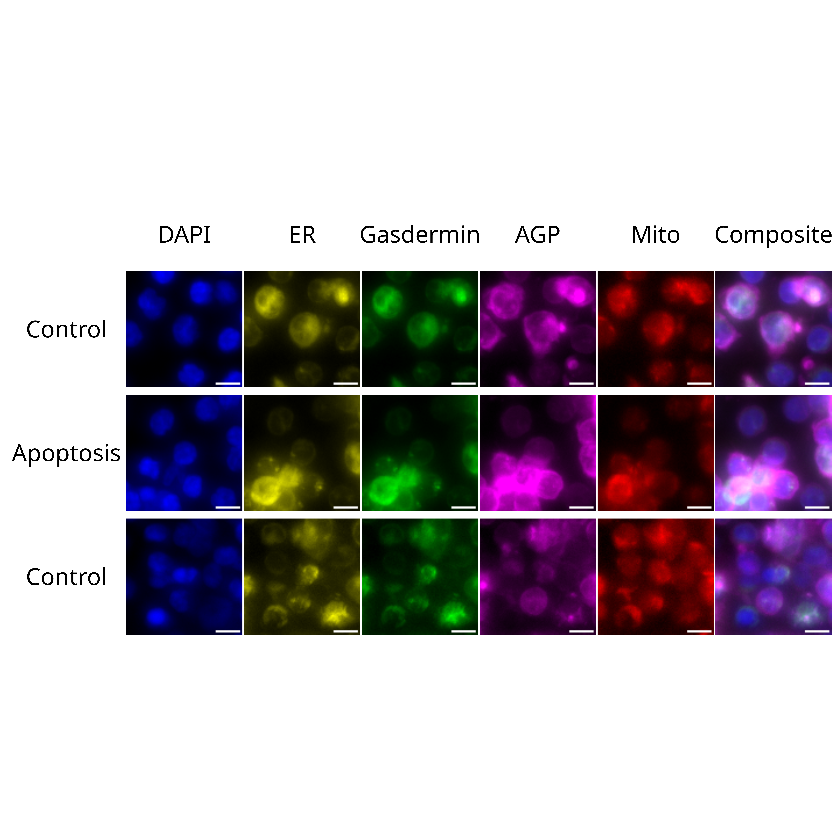

In [4]:
# plot the montage image to a ggplot object
montage <- (
    ggplot()
    + annotation_custom(
        rasterGrob(montage_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
montage


In [5]:
# set path to anova results
anova_results_path = file.path(paste0(
    "../../../1.Exploratory_Data_Analysis/results/",cell_type,"_combined.parquet"
))
# read in path
anova_results = arrow::read_parquet(anova_results_path)


In [6]:
# create a column that adds group1 and group2 together
anova_results$group = paste0(anova_results$group1,"_",anova_results$group2)
print(nrow(anova_results))
print(ncol(anova_results))


[1] 3735
[1] 12


In [7]:
# filter out rows that have p-adj_abs > 0.05
anova_results = anova_results %>% filter(`p-adj_abs` < 0.05)
print(nrow(anova_results))
print(ncol(anova_results))


[1] 2415
[1] 12


In [8]:
# change the group names to replace healhty with    control
anova_results$group = str_replace_all(anova_results$group,"healthy","control")


In [9]:
# create the three df sets for a venn diagram
a_h <- anova_results %>% filter(group == "apoptosis_control")
a_p <- anova_results %>% filter(group == "apoptosis_pyroptosis")
h_p <- anova_results %>% filter(group == "control_pyroptosis")
a_h <- a_h %>% select(features)
a_p <- a_p %>% select(features)
h_p <- h_p %>% select(features)

# create a list of the three df sets
a_h_list <- a_h %>% pull(features)
a_p_list <- a_p %>% pull(features)
h_p_list <- h_p %>% pull(features)

x=list(a_h_list,a_p_list,h_p_list)


In [10]:
# set plot size 
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
myCol <- brewer.pal(3, "Dark2")
venn_diagram_plot <- venn.diagram(
    x=x,
    show=TRUE,
    category.names = c("Apoptosis \nvs \nControl","Apoptosis \nvs \nPyroptosis","Control \nvs \nPyroptosis"),
    filename = paste0("../figures/",cell_type,"_venn_diagram.png"),
    # Output features
    imagetype="png" , 
    resolution = 600,
    compression = "lzw",
    
    # Circles
    lwd = 2,
    lty = 'blank',
    fill = myCol,
    
    # Numbers
    cex = 1,
    fontface = "bold",
    fontfamily = "sans",
    
    # Set names
    cat.cex = 0.8,
    cat.fontface = "bold",
    cat.default.pos = "outer",
    cat.pos = c(-26, 23, 0),
    cat.dist = c(-0.03, -0.03, -0.39),
    cat.fontfamily = "sans",
    rotation = 1

)


In [11]:
# Set the directory path
directory <- "../figures"
# List all files in the directory
files <- list.files(directory, full.names = TRUE)
# Filter files that end with ".log"
log_files <- files[grep(".log$", files)]
# Remove the log files
file.remove(log_files)


[1] TRUE

[1] "gg"     "ggplot"

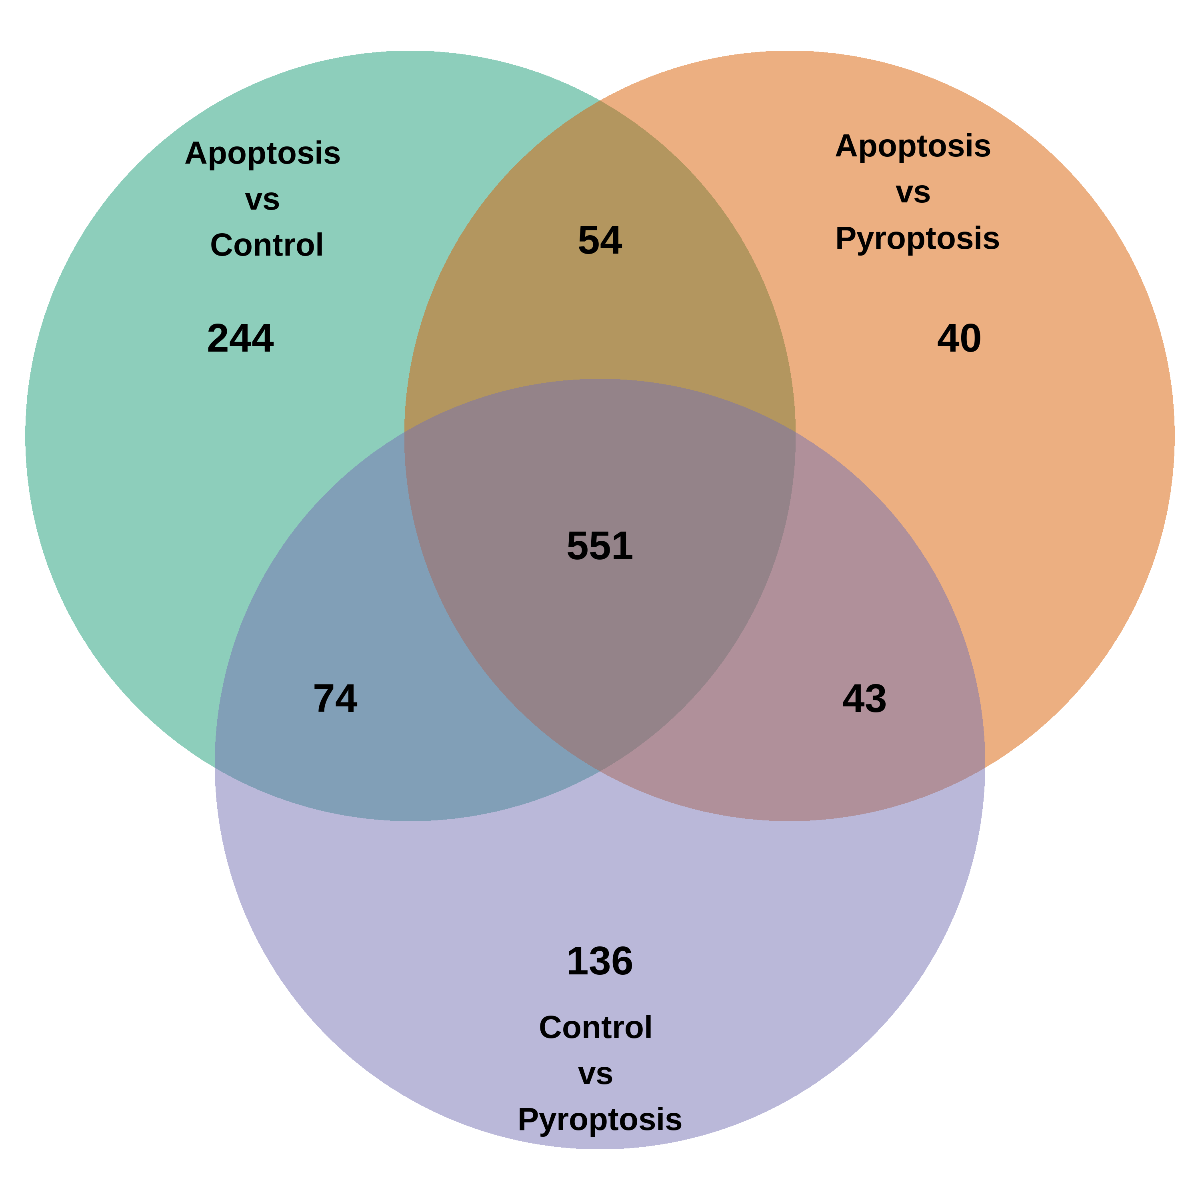

In [12]:
# read in the venn diagram from PNG
venn_diagram_image_path = file.path(paste0("../figures/",cell_type,"_venn_diagram.png"))
venn_diagram_image = png::readPNG(venn_diagram_image_path)
# plot the montage image to a ggplot object
venn_diagram_image <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn_diagram_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
# get the type of the object
class(venn_diagram_image)
venn_diagram_image


### Find the unique features for each class 
### Fins the overlapping features between classes

In [13]:
# add sets together
a_h__a_p <- union(a_h_list, a_p_list)
a_h__h_p <- union(a_h_list ,h_p_list)
a_p__h_p <- union(a_p_list ,h_p_list)

# get the unique features for each set
# Apoptosis_vs_Control
# should be 117
a_h_unique <- setdiff(a_h_list, a_p__h_p)
length(a_h_unique)

# Apoptosis_vs_Pyroptosis
# should be 17
a_p_unique <- setdiff(a_p_list, a_h__h_p)
length(a_p_unique)

# Control_vs_Pyroptosis
# should be 305
h_p_unique <- setdiff(h_p_list, a_h__a_p)
length(h_p_unique)


# get the common features for each set
# Apoptosis_vs_Control and Apoptosis_vs_Pyroptosis
# should be 5
a_h__a_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p_common <- setdiff(a_h__a_p_common, h_p_list)
length(a_h__a_p_common)

# Apoptosis_vs_Control and Control_vs_Pyroptosis
# should be 27
a_h__h_p_common <- intersect(a_h_list, h_p_list)
a_h__h_p_common <- setdiff(a_h__h_p_common, a_p_list)
length(a_h__h_p_common)

# Apoptosis_vs_Pyroptosis and Control_vs_Pyroptosis
# should be 16
a_p__h_p_common <- intersect(a_p_list, h_p_list)
a_p__h_p_common <- setdiff(a_p__h_p_common, a_h_list)
length(a_p__h_p_common)

# all three set intersection
# should be 406
a_h__a_p__h_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p__h_p_common <- intersect(a_h__a_p__h_p_common, h_p_list)
length(a_h__a_p__h_p_common)


[1] 244

[1] 40

[1] 136

[1] 54

[1] 74

[1] 43

[1] 551

#### Get df ready for plotting

In [14]:
anova_results_channels <- anova_results %>%
    # dplyr::arrange(desc(abs(group))) %>%
    tidyr::separate(
        features,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)
    # dplyr::arrange(desc(abs(group)))

# Clean channel for visualization
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_cleaned,
        "CorrDNA" = "nuclei",
        "CorrMito" = "Mito",
        "CorrER" = "ER",
        "CorrGasdermin" = "gasdermin",
        "CorrPM" = "PM",
        .default = "other",
        .missing="other"
    )
# rename the values in channel learned
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_learned,
        "nuclei" = "Nuclei",
        "Mito" = "Mito",
        "ER" = "ER",
        "gasdermin" = "GasderminD",
        "PM" = "AGP",
        .default = "other",
        .missing="Other"
    )
anova_results_channels$channel_learned <- factor(anova_results_channels$channel_learned, levels = c("Nuclei","Mito","ER","GasderminD","AGP","Other"))


Warning message:
“Expected 6 pieces. Additional pieces discarded in 458 rows [12, 16, 17, 18, 22,
23, 51, 52, 53, 58, 78, 79, 80, 85, 86, 89, 102, 103, 113, 146, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 539 rows [30, 31, 32, 33,
34, 35, 39, 40, 43, 48, 49, 50, 55, 56, 57, 59, 60, 61, 62, 69, ...].”


In [15]:
# select specfic colors from the color palette
DAPI <- brewer.pal(12,"Paired")[2]
ER <- brewer.pal(12,"Paired")[8]
Gasdermin <- brewer.pal(12,"Paired")[4]
PM <- brewer.pal(12,"Paired")[10]
Mito <- brewer.pal(12,"Paired")[6]
Other <- brewer.pal(8, "Accent")[8]


In [16]:
unique(anova_results_channels$channel_learned)

[1] Mito       Nuclei     AGP        ER         <NA>       GasderminD
Levels: Nuclei Mito ER GasderminD AGP Other

In [17]:
# factorize the channel_cleaned column
anova_results_channels$channel_learned <- factor(anova_results_channels$channel_learned, levels = c("Nuclei","ER","GasderminD","AGP","Mito","Other"))

In [18]:
# set plot size
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
unique_feature_plot_function <- function(df, list_of_unique_features){
    filtered_df <- df %>% filter(features %in% list_of_unique_features)
    # drop duplicate features
    filtered_df <- filtered_df[!duplicated(filtered_df$features),]
    # count the data
    filtered_df_counts <- count(filtered_df, channel_learned)
    # make <NA> vlues in channel_learned Other
    filtered_df_counts$channel_learned <- replace_na(filtered_df_counts$channel_learned, "Other")
    plot <- (
        ggplot(filtered_df_counts, aes(x=channel_learned, y=n, fill=channel_learned))
        + geom_bar(stat = "identity")
        + theme_bw()
        # change colours of bars manually
        + scale_fill_manual(values = c("Nuclei" = DAPI, "Mito" = Mito, "ER" = ER, "GasderminD" = Gasdermin, "AGP" = PM, "Other" = Other))
        + labs(
            x = "Channel",
            y = "Number of Features",
        )
        # legend title change
        
        + guides(fill = guide_legend(title = "Channel"))
        + figure_theme
        # drop the x axis ticks
        + theme(
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank()
        )
        # add the counts to the top of the bars
        + geom_text(
            aes(label=n),
            vjust=-0.5,
            size=8
        )
        + ylim(0, 150)
        
    )
    plot <- plot + scale_x_discrete(drop = FALSE)
    return(plot)
}

a_h_unique_plot <- unique_feature_plot_function(anova_results_channels, a_h_unique)
a_p_unique_plot <- unique_feature_plot_function(anova_results_channels, a_p_unique)
h_p_unique_plot <- unique_feature_plot_function(anova_results_channels, h_p_unique)
a_h__a_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p_common)
a_h__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__h_p_common)
a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_p__h_p_common)
a_h__a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p__h_p_common)

# add titles to each plot
a_h_unique_plot <- a_h_unique_plot + labs(title = "Apoptosis vs Control")
a_p_unique_plot <- a_p_unique_plot + labs(title = "Apoptosis vs Pyroptosis")
h_p_unique_plot <- h_p_unique_plot + labs(title = "Control vs Pyroptosis")
a_h__a_p_common_plot <- a_h__a_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Apoptosis vs Pyroptosis")
a_h__h_p_common_plot <- a_h__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Control vs Pyroptosis")
a_p__h_p_common_plot <- a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Pyroptosis and Control vs Pyroptosis")
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control, Apoptosis vs Pyroptosis and Control vs Pyroptosis")


## UMAP of morphological features

In [19]:
cell_umap_path <- file.path(paste0(
    "../","../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_sample_100.parquet"
))

cell_umap <- arrow::read_parquet(cell_umap_path)

In [20]:

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)

pyroptosis_ground_truth_list
control_ground_truth_list

[1] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"                     
 [2] "Flagellin_1.000_ug_per_ml_DMSO_0.0_%"                       
 [3] "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM"              
 [4] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                           
 [5] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                           
 [6] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                           
 [7] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                          
 [8] "LPS_10.000_ug_per_ml_Disulfiram_0.100_uM"                   
 [9] "LPS_10.000_ug_per_ml_Disulfiram_1.000_uM"                   
[10] "LPS_10.000_ug_per_ml_Disulfiram_2.500_uM"                   
[11] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                         
[12] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%"        
[13] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"       
[14] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM"
[15] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%"        
[16] "LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%"      
[17] "LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%"     
[18] "LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%"

[1] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [2] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"                      
 [3] "DMSO_0.100_%_DMSO_1.000_%"                                   
 [4] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"                           
 [5] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
 [6] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
 [7] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
 [8] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
 [9] "H2O2_100.000_nM_DMSO_0.025_%"                                
[10] "H2O2_100.000_uM_DMSO_0.025_%"                                
[11] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[12] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[13] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[14] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
[15] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[16] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[17] "Topotecan_5.000_nM_DMSO_0.025_%"                             
[18] "media_ctr_0.0_0_Media_0.0_0"                                 
[19] "media_ctr_0.0_0_Media_ctr_0.0_0"

In [21]:


# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
cell_umap$group <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cell_umap$group <- factor(cell_umap$group, levels = c("Control","Apoptosis", "Pyroptosis"))

unique(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)


[1] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
 [2] "LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%"       
 [3] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"        
 [4] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [5] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%"         
 [6] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                            
 [7] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"                      
 [8] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                           
 [9] "H2O2_100.000_nM_DMSO_0.025_%"                                
[10] "DMSO_0.100_%_DMSO_1.000_%"                                   
[11] "LPS_10.000_ug_per_ml_Disulfiram_1.000_uM"                    
[12] "Thapsigargin_10.000_uM_DMSO_0.025_%"                         
[13] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
[14] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM" 
[15] "Thapsigargin_1.000_uM_DMSO_0.025_%"                          
[16] "LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%"       
[17] "H2O2_100.000_uM_DMSO_0.025_%"                                
[18] "Flagellin_1.000_ug_per_ml_DMSO_0.0_%"                        
[19] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%"         
[20] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
[21] "media_ctr_0.0_0_Media_ctr_0.0_0"                             
[22] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                          
[23] "LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%"      
[24] "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM"               
[25] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[26] "LPS_10.000_ug_per_ml_Disulfiram_0.100_uM"                    
[27] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                            
[28] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[29] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"                      
[30] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
[31] "Topotecan_5.000_nM_DMSO_0.025_%"                             
[32] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[33] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[34] "LPS_10.000_ug_per_ml_Disulfiram_2.500_uM"                    
[35] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
[36] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[37] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                            
[38] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"

In [22]:
# mutate the names of each treatment

cell_umap <- cell_umap %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

unique(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

[1] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM"
 [2] "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"      
 [3] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"       
 [4] "DMSO 0.1% - DMSO 0.025%"                               
 [5] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"        
 [6] "LPS 0.1 ug/ml - DMSO 0.025%"                           
 [7] "Flagellin 0.1 ug/ml - DMSO 0.025%"                     
 [8] "LPS 10.0 ug/ml - DMSO 0.025%"                          
 [9] "H2O2 100.0 nM - DMSO 0.025%"                           
[10] "DMSO 0.1% - DMSO 1.0%"                                 
[11] "LPS 10.0 ug/ml - Disulfiram 1.0 uM"                    
[12] "Thapsigargin 10.0 uM - DMSO 0.025%"                    
[13] "Disulfiram 0.1 uM - DMSO 0.025%"                       
[14] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM" 
[15] "Thapsigargin 1.0 uM - DMSO 0.025%"                     
[16] "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"      
[17] "H2O2 100.0 uM - DMSO 0.025%"                           
[18] "Flagellin 1.0 ug/ml - DMSO 0.025%"                     
[19] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"        
[20] "DMSO 0.1% - Z-VAD-FMK 30.0 uM"                         
[21] "Media"                                                 
[22] "LPS 100.0 ug/ml - DMSO 0.025%"                         
[23] "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"     
[24] "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM"               
[25] "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM"                   
[26] "LPS 10.0 ug/ml - Disulfiram 0.1 uM"                    
[27] "LPS 1.0 ug/ml - DMSO 0.025%"                           
[28] "Topotecan 20.0 nM - DMSO 0.025%"                       
[29] "Disulfiram 1.0 uM - DMSO 0.025%"                       
[30] "Topotecan 5.0 nM - DMSO 0.025%"                        
[31] "Topotecan 10.0 nM - DMSO 0.025%"                       
[32] "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM"                    
[33] "LPS 10.0 ug/ml - Disulfiram 2.5 uM"                    
[34] "Disulfiram 2.5 uM - DMSO 0.025%"                       
[35] "H2O2 100.0 uM - Disulfiram 1.0 uM"                     
[36] "LPS 0.01 ug/ml - DMSO 0.025%"                          
[37] "DMSO 0.1% - Z-VAD-FMK 100.0 uM"

In [23]:
unique(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

[1] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM"
 [2] "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"      
 [3] "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"       
 [4] "DMSO 0.1% - DMSO 0.025%"                               
 [5] "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"        
 [6] "LPS 0.1 ug/ml - DMSO 0.025%"                           
 [7] "Flagellin 0.1 ug/ml - DMSO 0.025%"                     
 [8] "LPS 10.0 ug/ml - DMSO 0.025%"                          
 [9] "H2O2 100.0 nM - DMSO 0.025%"                           
[10] "DMSO 0.1% - DMSO 1.0%"                                 
[11] "LPS 10.0 ug/ml - Disulfiram 1.0 uM"                    
[12] "Thapsigargin 10.0 uM - DMSO 0.025%"                    
[13] "Disulfiram 0.1 uM - DMSO 0.025%"                       
[14] "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM" 
[15] "Thapsigargin 1.0 uM - DMSO 0.025%"                     
[16] "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%"      
[17] "H2O2 100.0 uM - DMSO 0.025%"                           
[18] "Flagellin 1.0 ug/ml - DMSO 0.025%"                     
[19] "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%"        
[20] "DMSO 0.1% - Z-VAD-FMK 30.0 uM"                         
[21] "Media"                                                 
[22] "LPS 100.0 ug/ml - DMSO 0.025%"                         
[23] "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%"     
[24] "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM"               
[25] "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM"                   
[26] "LPS 10.0 ug/ml - Disulfiram 0.1 uM"                    
[27] "LPS 1.0 ug/ml - DMSO 0.025%"                           
[28] "Topotecan 20.0 nM - DMSO 0.025%"                       
[29] "Disulfiram 1.0 uM - DMSO 0.025%"                       
[30] "Topotecan 5.0 nM - DMSO 0.025%"                        
[31] "Topotecan 10.0 nM - DMSO 0.025%"                       
[32] "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM"                    
[33] "LPS 10.0 ug/ml - Disulfiram 2.5 uM"                    
[34] "Disulfiram 2.5 uM - DMSO 0.025%"                       
[35] "H2O2 100.0 uM - Disulfiram 1.0 uM"                     
[36] "LPS 0.01 ug/ml - DMSO 0.025%"                          
[37] "DMSO 0.1% - Z-VAD-FMK 100.0 uM"

In [24]:
unique(cell_umap$group)

[1] Control    Pyroptosis Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [25]:
# create grouping of treatment and group
cell_umap$group_treatment <- paste(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, cell_umap$group,  sep = ", ")
# make the group_treatment column a factor
cell_umap$group_treatment <- factor(
    cell_umap$group_treatment, 
    levels = c(
        levels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
    
)
    )
)
length(unique(cell_umap$group_treatment))

[1] 37

In [26]:
custom_pallette = createPalette(37,  c("#ff0000", "#00ff00", "#0000ff"))
custom_pallette <- sortByHue(custom_pallette)
custom_pallette <- as.vector(t(matrix(custom_pallette, ncol=4)))


Warning message in matrix(custom_pallette, ncol = 4):
“data length [37] is not a sub-multiple or multiple of the number of rows [10]”


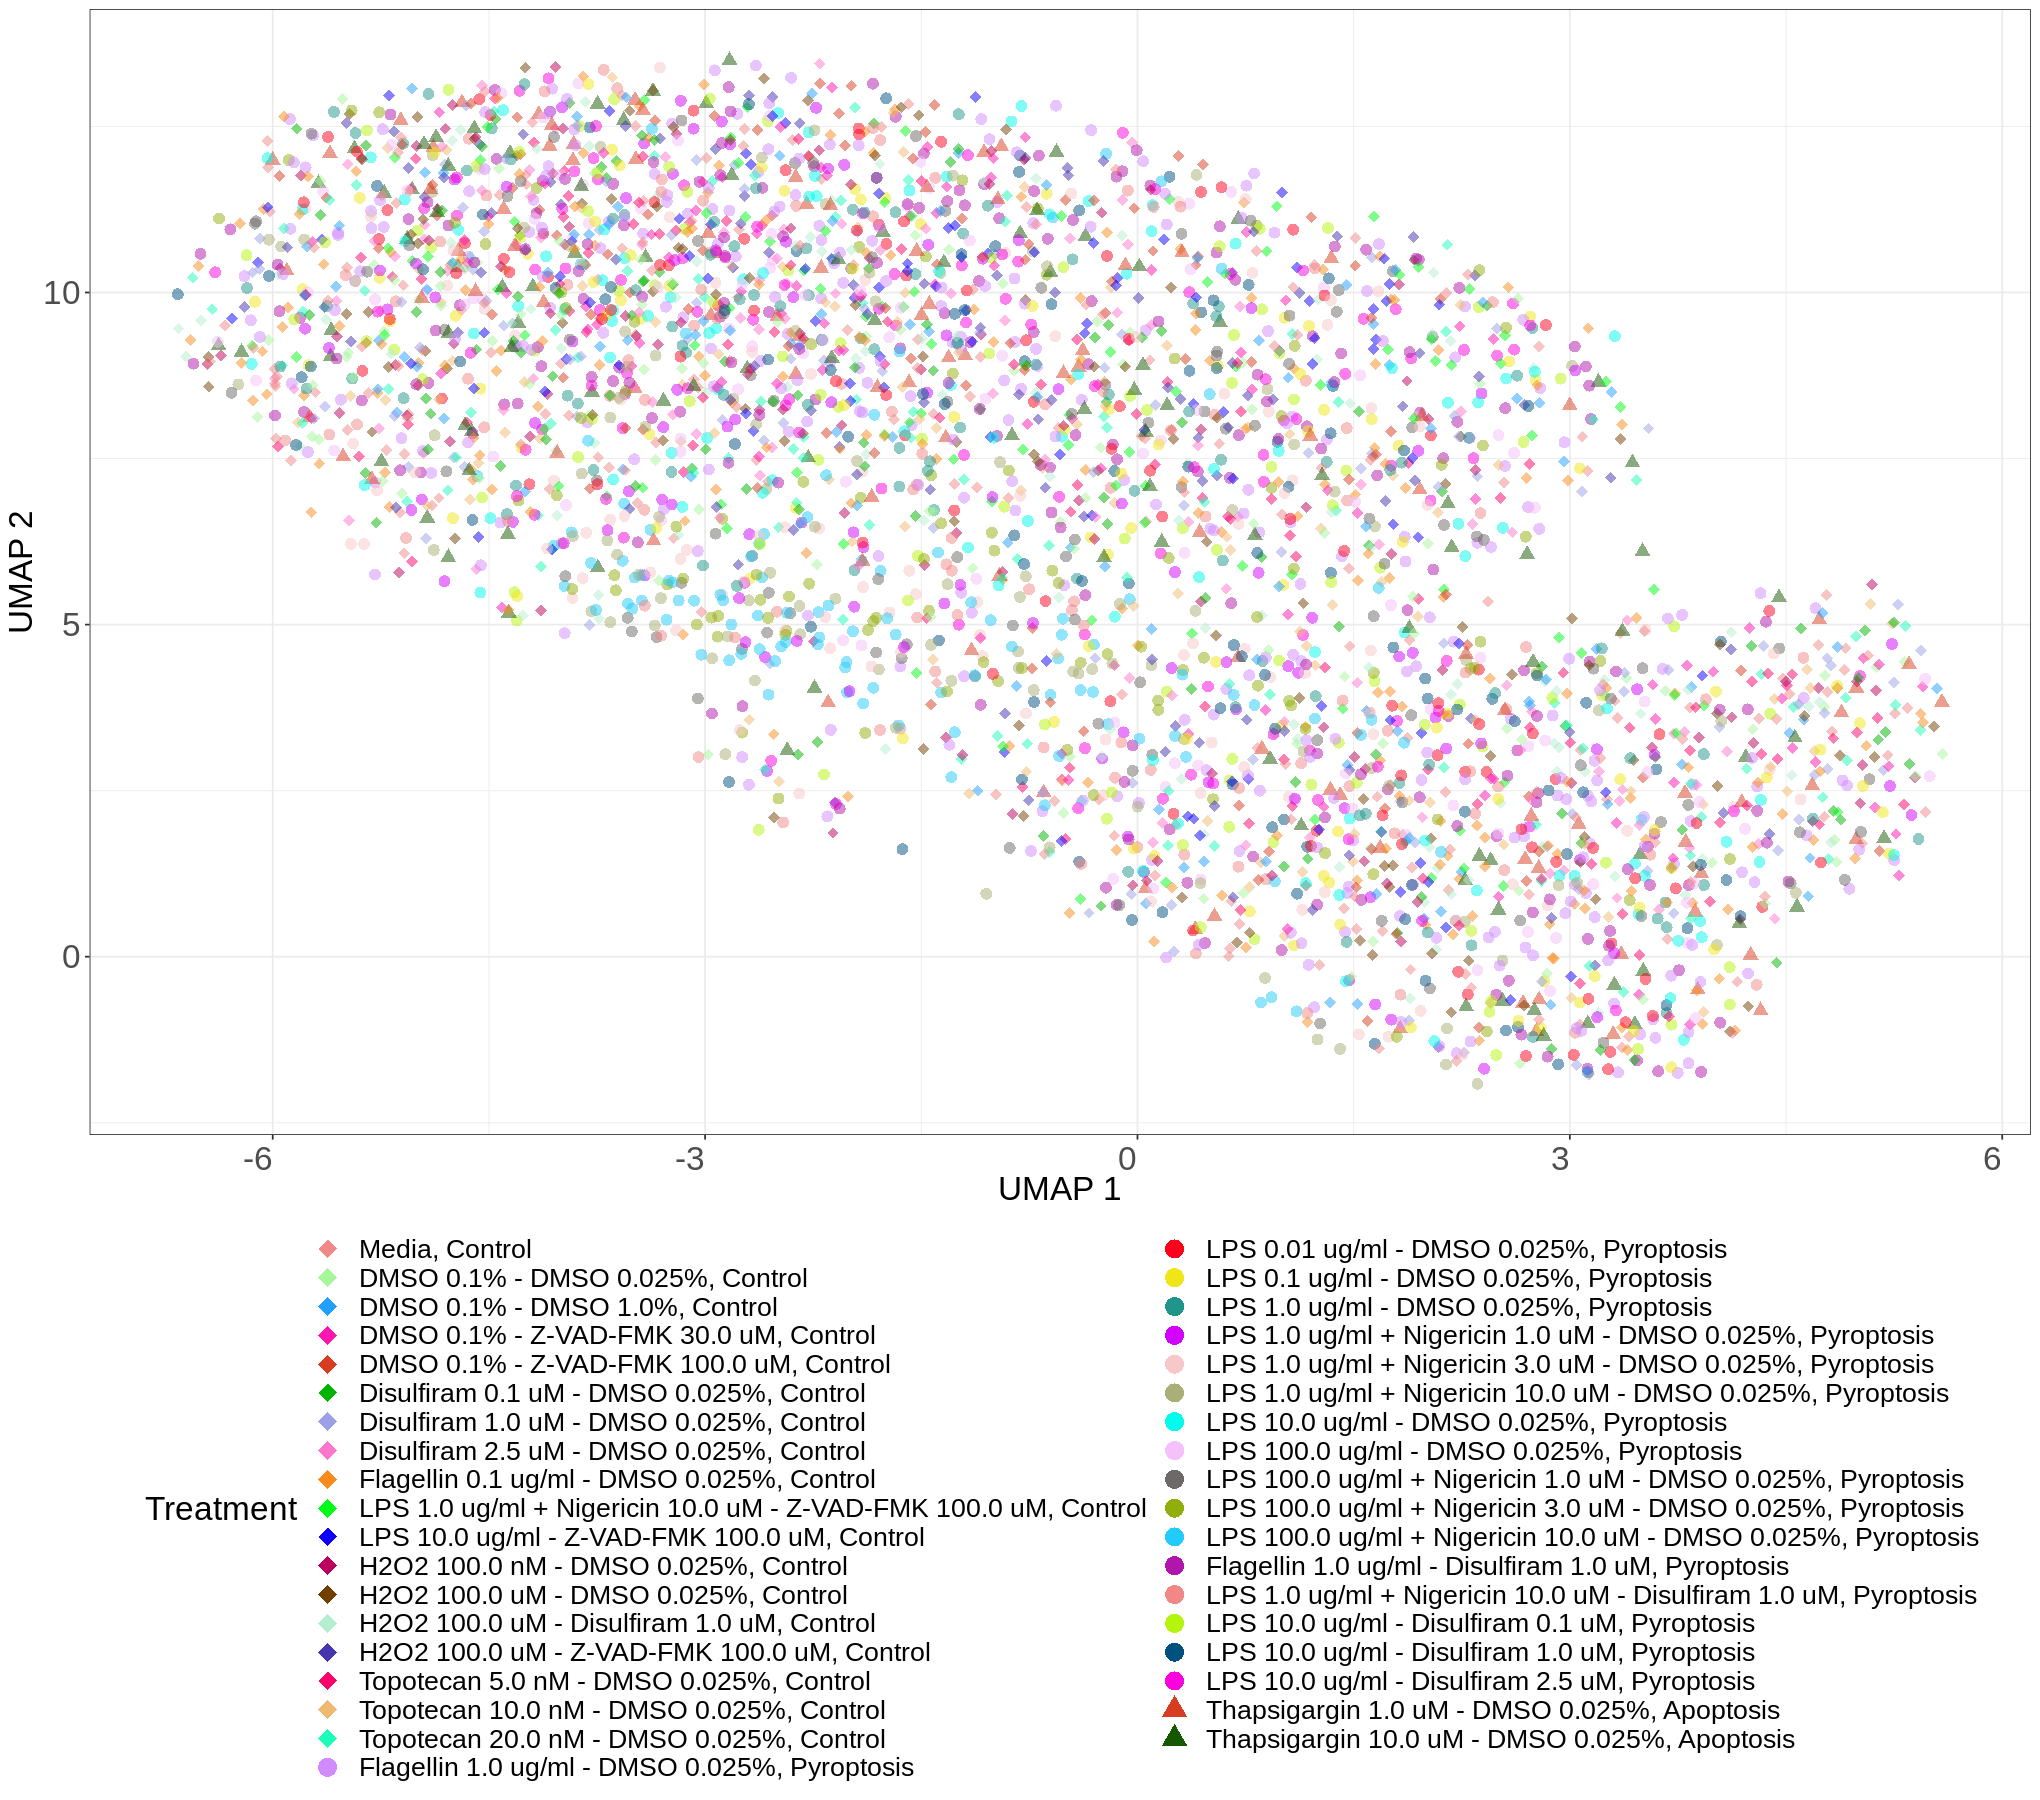

In [27]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_all <- (
    ggplot(cell_umap, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = group_treatment,
            shape = group_treatment
        ), 
        size = 3, 
        alpha = 0.5
    )
    + theme_bw()

    # rename legend title
    + labs(color = "Treatment", hjust = 0.5)
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
         legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = custom_pallette)
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
            'Media, Control',
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Control',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'Topotecan 5.0 nM - DMSO 0.025%, Control',
            'Topotecan 10.0 nM - DMSO 0.025%, Control',
            'Topotecan 20.0 nM - DMSO 0.025%, Control',


            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',

            'Thapsigargin 1.0 uM - DMSO 0.025%, Apoptosis',
            'Thapsigargin 10.0 uM - DMSO 0.025%, Apoptosis'
        ),
        values = c(
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            18,
            
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16, 
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            16,
            17,
            17
        )
    )
    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol =2, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP 1",
        y = "UMAP 2"
    )   
)
umap_plot_all


## Selected features for each class UMAP

In [28]:
# re-read in the cell_umap df
cell_umap_path <- file.path(paste0(
    "../","../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_sample_100.parquet"
))

cell_umap <- arrow::read_parquet(cell_umap_path)
toml_path <- file.path("..","..","../","1.Exploratory_Data_Analysis/utils/params.toml")
p <- parseTOML(toml_path)
# get the list that is in the toml file under the key "treatments"
# define that list as a variable called list_of_treatments and print the list to verify
list_of_treatments <- c(p$list_of_treatments$treatments)
# subset the df by the list of treatments
cell_umap_selected_treatments <- cell_umap %>% filter(oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% list_of_treatments)
head(cell_umap_selected_treatments)


Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,Cytoplasm_AreaShape_Zernike_1_1,Cytoplasm_AreaShape_Zernike_2_0,Cytoplasm_AreaShape_Zernike_2_2,Cytoplasm_AreaShape_Zernike_3_1,⋯,Nuclei_Texture_InverseDifferenceMoment_CorrPM_3_03_256,Nuclei_Texture_SumEntropy_CorrPM_3_01_256,Nuclei_Texture_SumVariance_CorrPM_3_01_256,Nuclei_Texture_Variance_CorrER_3_00_256,Nuclei_Texture_Variance_CorrGasdermin_3_00_256,umap_1,umap_2,oneb_Metadata_Treatment_Dose_Inhibitor_Dose,__index_level_0__,__index_level_1__
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
0.04458081,-0.2291663309,-0.3167262,-0.89925765,-1.1030220,-0.68043480,-0.6386509,-0.9854598,0.3214117,-0.4288594,⋯,1.366918,-1.8030197,-0.1676858066,-0.19465699,-0.19312463,-2.095922,5.390349,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%,LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%,4135253
0.57605261,-0.5914704046,-0.0652136,0.85676710,-1.4871873,-0.60385952,-0.5873071,1.0431710,-0.8796077,-0.3671088,⋯,1.081407,-0.8374835,-0.1575222483,-0.20500114,-0.19065284,-4.475632,9.272793,DMSO_0.100_%_DMSO_0.025_%,DMSO_0.100_%_DMSO_0.025_%,2756279
-0.24101402,0.0005652865,-0.3611522,-0.27966145,0.9809175,0.55256609,0.8588446,-0.1983269,0.6690683,2.2089262,⋯,-1.075240,0.9349406,0.0007495165,0.17148018,0.15491151,1.114986,4.273778,LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%,LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%,3722431
-0.60057746,0.3344381520,-0.8929653,-0.92291989,0.5022947,0.08376447,-0.6235339,1.2532222,-0.4123834,-0.5082313,⋯,1.145464,-1.5690851,-0.1634222776,-0.16434904,-0.16117341,-3.443907,9.606824,LPS_0.100_ug_per_ml_DMSO_0.025_%,LPS_0.100_ug_per_ml_DMSO_0.025_%,542470
0.76921927,-0.7059583441,-0.1298470,0.89419136,0.7832220,0.22530281,1.2210303,-0.5569302,-0.7436678,-1.3764441,⋯,-1.545745,1.0504143,0.0052952316,-0.05170628,-0.06749674,3.187853,3.122525,LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%,LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%,3718497
-0.03571149,-0.1673740140,-0.2875214,-0.04083591,1.5829486,-0.54247755,-0.7462511,0.5559771,-0.2275664,-1.1882751,⋯,1.424654,-1.4996775,-0.1634407113,-0.16894646,-0.16472426,-2.909426,8.541862,LPS_10.000_ug_per_ml_DMSO_0.025_%,LPS_10.000_ug_per_ml_DMSO_0.025_%,918619


In [29]:
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)


# make a new column that is the treatment group based on the ground truth data
cell_umap_selected_treatments$group <- ifelse(cell_umap_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cell_umap_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cell_umap_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cell_umap_selected_treatments$group <- factor(cell_umap_selected_treatments$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [30]:


# mutate the names of each treatment
cell_umap_selected_treatments <- cell_umap_selected_treatments %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "DMSO_0.100_%_DMSO_0.025_%" ~ "DMSO 0.1%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.025_%" ~ "Flagellin 1.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM"
    ))

     


In [31]:
# create grouping of treatment and group
cell_umap_selected_treatments$group_treatment <- paste(cell_umap_selected_treatments$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, cell_umap_selected_treatments$group,  sep = ", ")
# make the group_treatment column a factor
cell_umap_selected_treatments$group_treatment <- factor(
    cell_umap_selected_treatments$group_treatment, 
    levels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
    )
)

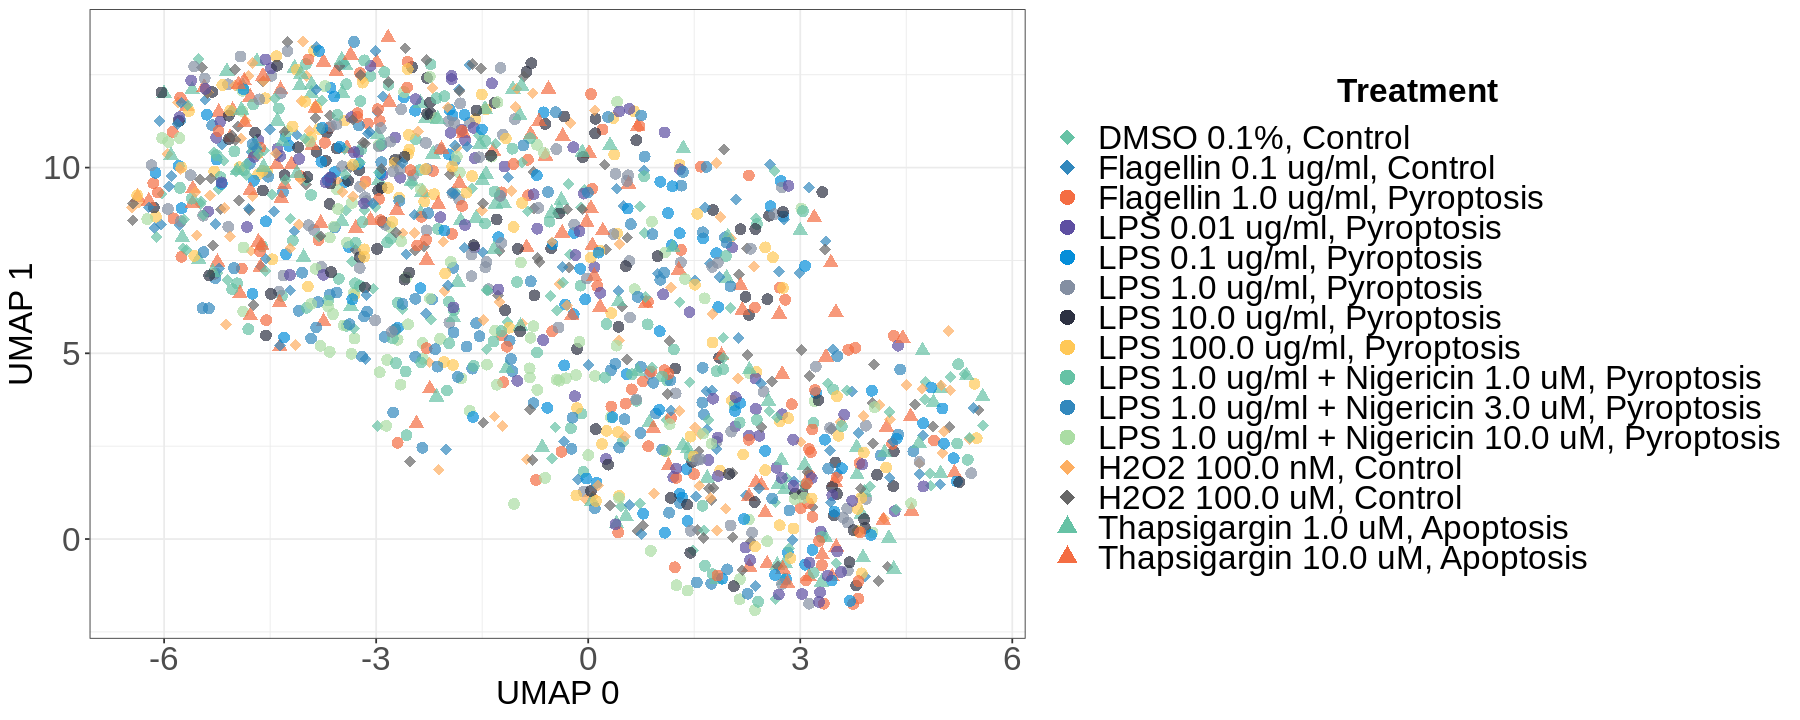

In [32]:
# set plot size 
width <- 15
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_selected <- (
    ggplot(cell_umap_selected_treatments, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = group_treatment,
            shape = group_treatment
        ), 
        size = 3, 
        alpha = 0.7
    )
    + theme_bw()
    + figure_theme
    + guides(
        color = guide_legend(
            override.aes = list(
                size = 4,
                alpha = 1.5
            )
        )
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment",
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    + theme(
        # change title size
        plot.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
        legend.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
    )
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = c(
        '#66c2a5',
        '#3288bd',
        '#f46d43',
        '#5e4fa2',
        "#058ED9",
        "#848FA2",
        "#2D3142",
        "#FFC857",
        '#66c2a5',
        '#3288bd',
        '#abdda4',
        '#fdae61',
        # dark grey
        '#666666',
        # greenoneb_Treatment_Dose_Inhibitor_Dose
        '#66c2a5',
        '#f46d43',
        '#d53e4f'
        ))
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
        'DMSO 0.1%, Control',
        'Flagellin 0.1 ug/ml, Control',
        'Flagellin 1.0 ug/ml, Pyroptosis',
        'LPS 0.01 ug/ml, Pyroptosis',
        'LPS 0.1 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml, Pyroptosis',
        'LPS 10.0 ug/ml, Pyroptosis',
        'LPS 100.0 ug/ml, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 1.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM, Pyroptosis',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM, Pyroptosis',
        'H2O2 100.0 nM, Control',
        'H2O2 100.0 uM, Control',
        'Thapsigargin 1.0 uM, Apoptosis',
        'Thapsigargin 10.0 uM, Apoptosis'
        ),
        values = c(
        18,
        18,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        16,
        18,
        18,
        17,
        17
        ))


)
umap_plot_legend <- get_legend(umap_plot_selected)
# umap_plot <- umap_plot + theme(legend.position = "none")
# remove the title 
umap_plot_selected <- umap_plot_selected + theme(plot.title = element_blank())
umap_plot_selected


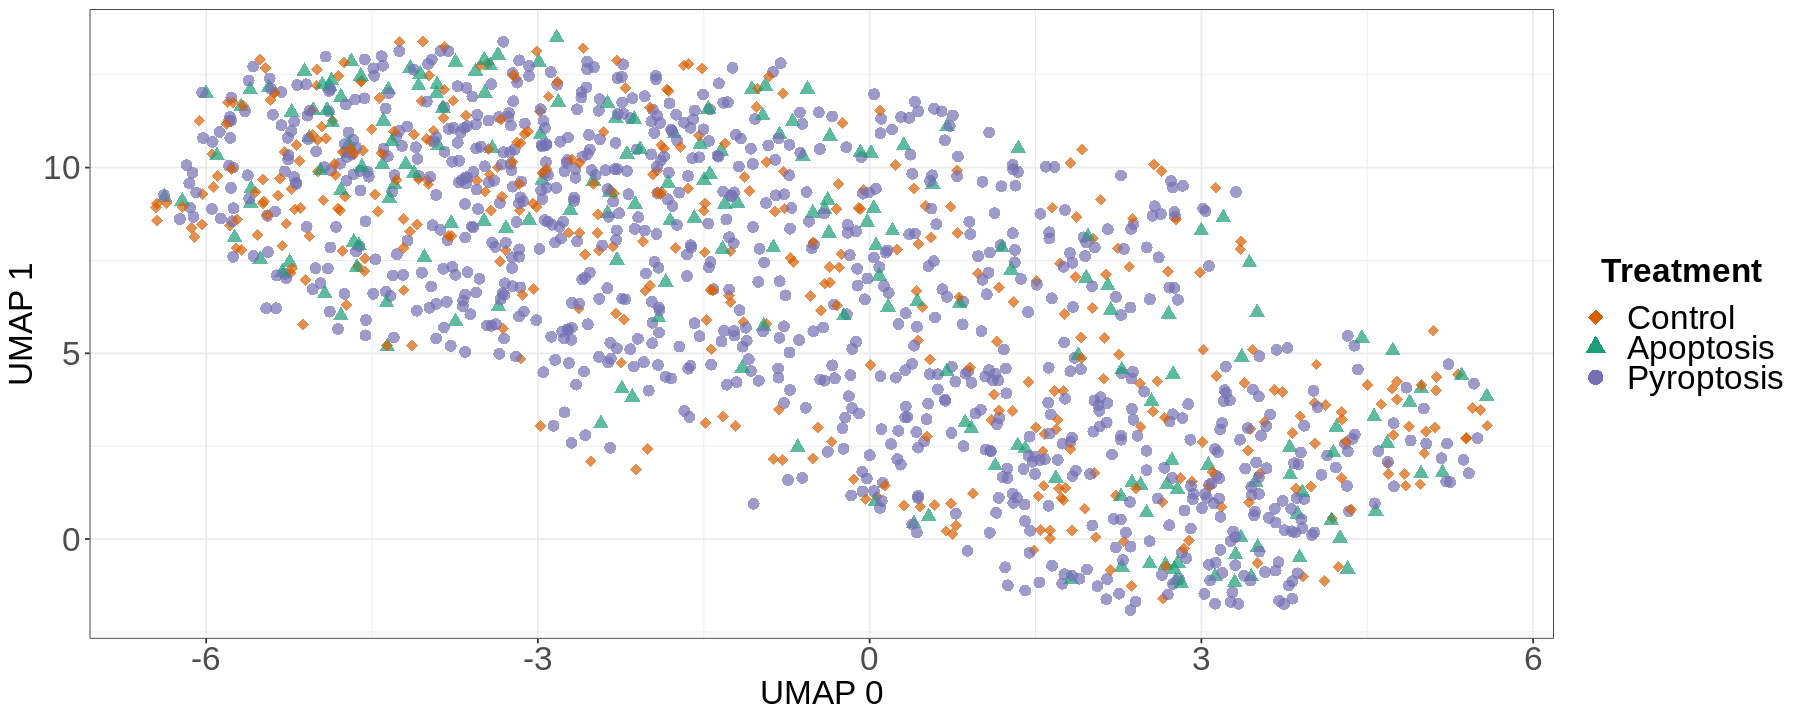

In [33]:
# set plot size 
width <- 15
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_selected_death_type <- (
    ggplot(cell_umap_selected_treatments, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = group,
            shape = group
        ), 
        size = 3, 
        alpha = 0.7
    )
    + theme_bw()
    + figure_theme
    + guides(
        color = guide_legend(
            override.aes = list(
                size = 4,
                alpha = 1.5
            )
        )
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment",
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    + theme(
        # change title size
        plot.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
        legend.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
    )
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
        ))
    + scale_shape_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
        18,
        17,
        16
        ))

)
# remove the title 
umap_plot_selected_death_type <- umap_plot_selected_death_type + theme(plot.title = element_blank())
umap_plot_selected_death_type


## Adjust bar plots

In [34]:
# change bar plot title colours to match the venn diagram

a_h_unique_plot <- a_h_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[1], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_p_unique_plot <- a_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[2], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
h_p_unique_plot <- h_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[3], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + ggtitle(
    "All Common Features"
) + theme(
    plot.title = element_text(
        color="black", 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()

)

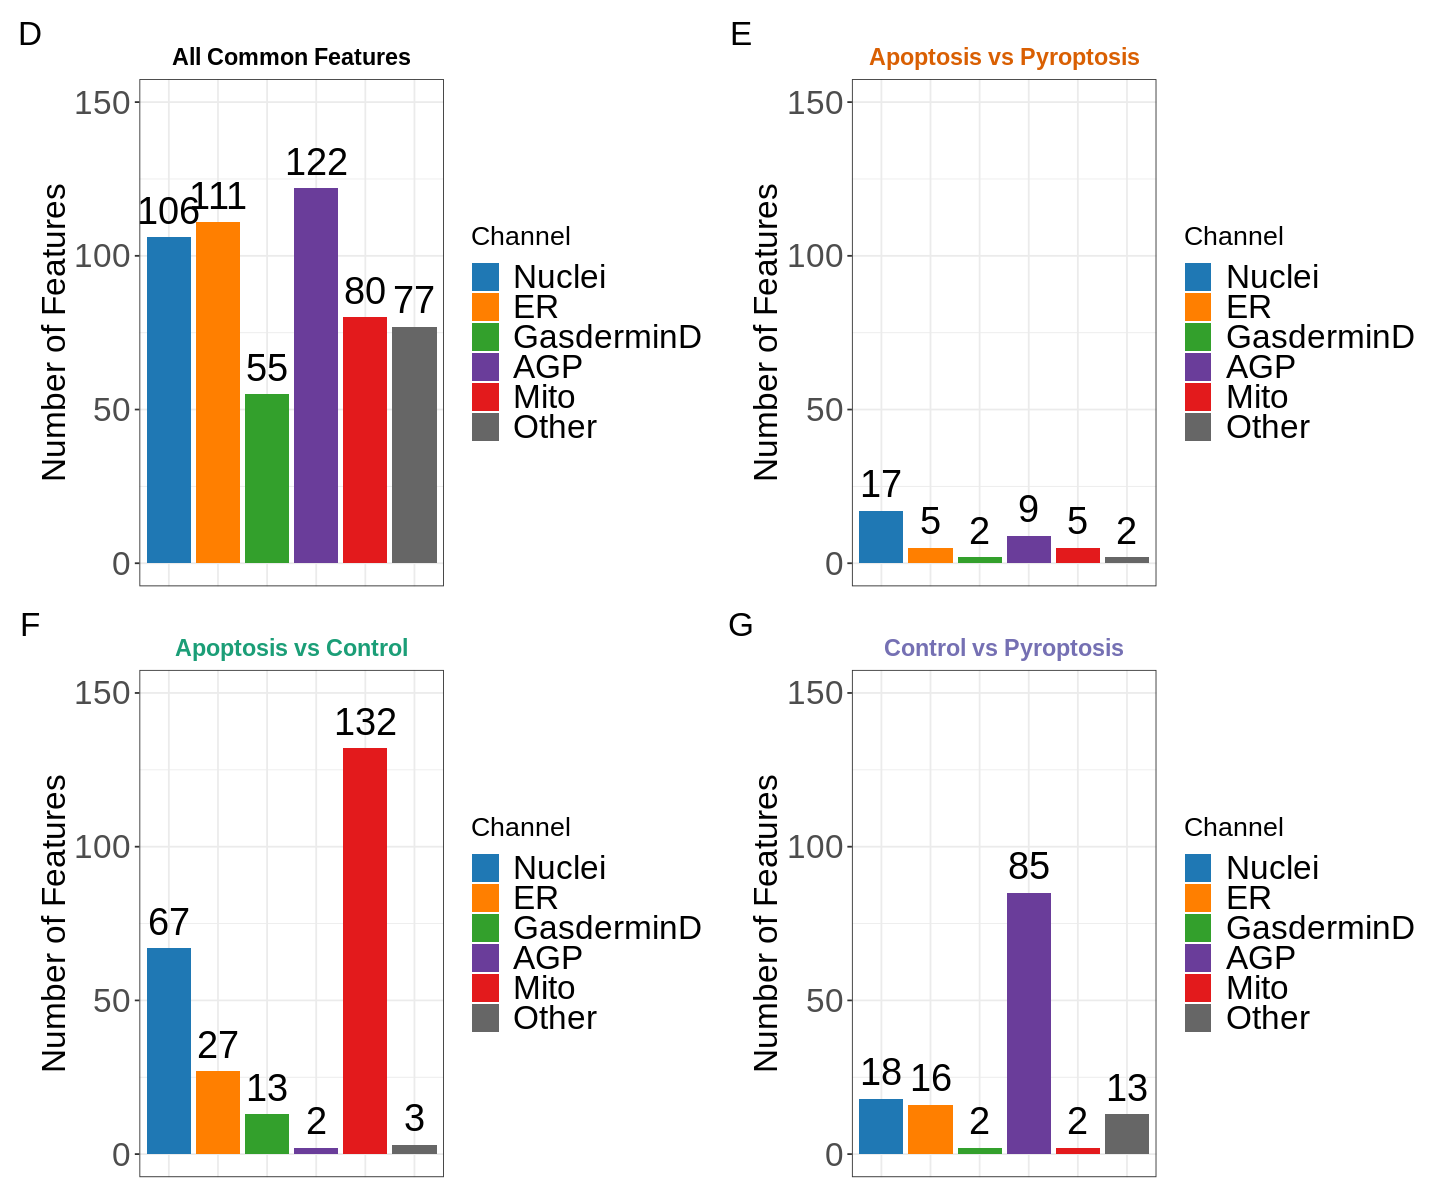

In [35]:
# patch work plot of the venn diagram and bar plots


layout <- c(
    area(t=1, b=2, l=1, r=2), 
    area(t=1, b=2, l=3, r=4), 
    area(t=3, b=4, l=1, r=2), 
    area(t=3, b=4, l=3, r=4)
)

# set plot size
width <- 12
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
sub_figure3 <- (
    a_h__a_p__h_p_common_plot
    + a_p_unique_plot
    + a_h_unique_plot
    
    + h_p_unique_plot
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = list(c( "D", "E", "F", "G"))) & theme(plot.tag = element_text(size = 20))

)
sub_figure3


## Plot the distibution of the selected features for each class

In [36]:
# import morphology data 
columns_to_import <- c("oneb_Metadata_Treatment_Dose_Inhibitor_Dose", "Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1")
# path to the parquet file
morphology_path <- file.path(
    "..","..","..","data","PBMC_preprocessed_sc_norm.parquet"
)

# read in the parquet file with certain columns
morphology_df <- arrow::read_parquet(morphology_path, col_select = all_of(columns_to_import))

# read in the specific image values
image_values_path <- file.path(
    "..","results","features_values.csv"
)
features_values <- read_csv(image_values_path)
control_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[1]
apoptosis_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[2]
pyroptosis_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[3]


Rows: 3 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): oneb_Metadata_Treatment_Dose_Inhibitor_Dose, group, Metadata_Well,...
dbl (10): Metadata_Nuclei_Location_Center_Y, Metadata_Nuclei_Location_Center...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)


length(unique(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose))
unique(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

[1] 38

[1] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                            
 [2] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                            
 [3] "LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%"       
 [4] "LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%"       
 [5] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [6] "media_ctr_0.0_0_Media_ctr_0.0_0"                             
 [7] "DMSO_0.100_%_DMSO_1.000_%"                                   
 [8] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                            
 [9] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                           
[10] "LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%"      
[11] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
[12] "Thapsigargin_1.000_uM_DMSO_0.025_%"                          
[13] "Thapsigargin_10.000_uM_DMSO_0.025_%"                         
[14] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"                           
[15] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
[16] "LPS_10.000_ug_per_ml_Disulfiram_0.100_uM"                    
[17] "LPS_10.000_ug_per_ml_Disulfiram_1.000_uM"                    
[18] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
[19] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
[20] "Topotecan_5.000_nM_DMSO_0.025_%"                             
[21] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[22] "LPS_10.000_ug_per_ml_Disulfiram_2.500_uM"                    
[23] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[24] "H2O2_100.000_nM_DMSO_0.025_%"                                
[25] "H2O2_100.000_uM_DMSO_0.025_%"                                
[26] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[27] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                          
[28] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%"         
[29] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[30] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[31] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%"         
[32] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"        
[33] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"                      
[34] "Flagellin_1.000_ug_per_ml_DMSO_0.0_%"                        
[35] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"                      
[36] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM" 
[37] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
[38] "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM"

In [38]:
# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

# make a new column that is the treatment group based on the ground truth data
morphology_df$group <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
morphology_df$group <- factor(morphology_df$group, levels = c("Control","Apoptosis", "Pyroptosis"))

unique(morphology_df$group)


[1] Pyroptosis Control    Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [39]:
head(morphology_df)
# get only rows that contain the control or apoptosis or pyroptosis
control_df <- morphology_df %>% filter(group == "Control")
apoptosis_df <- morphology_df %>% filter(group == "Apoptosis")
pyroptosis_df <- morphology_df %>% filter(group == "Pyroptosis")

oneb_Metadata_Treatment_Dose_Inhibitor_Dose,Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1,group
<chr>,<dbl>,<fct>
LPS_0.010_ug_per_ml_DMSO_0.025_%,1.4920698,Pyroptosis
LPS_0.010_ug_per_ml_DMSO_0.025_%,0.8715299,Pyroptosis
LPS_0.010_ug_per_ml_DMSO_0.025_%,-0.7502727,Pyroptosis
LPS_0.010_ug_per_ml_DMSO_0.025_%,1.1844743,Pyroptosis
LPS_0.010_ug_per_ml_DMSO_0.025_%,1.6306142,Pyroptosis
LPS_0.010_ug_per_ml_DMSO_0.025_%,0.5618248,Pyroptosis


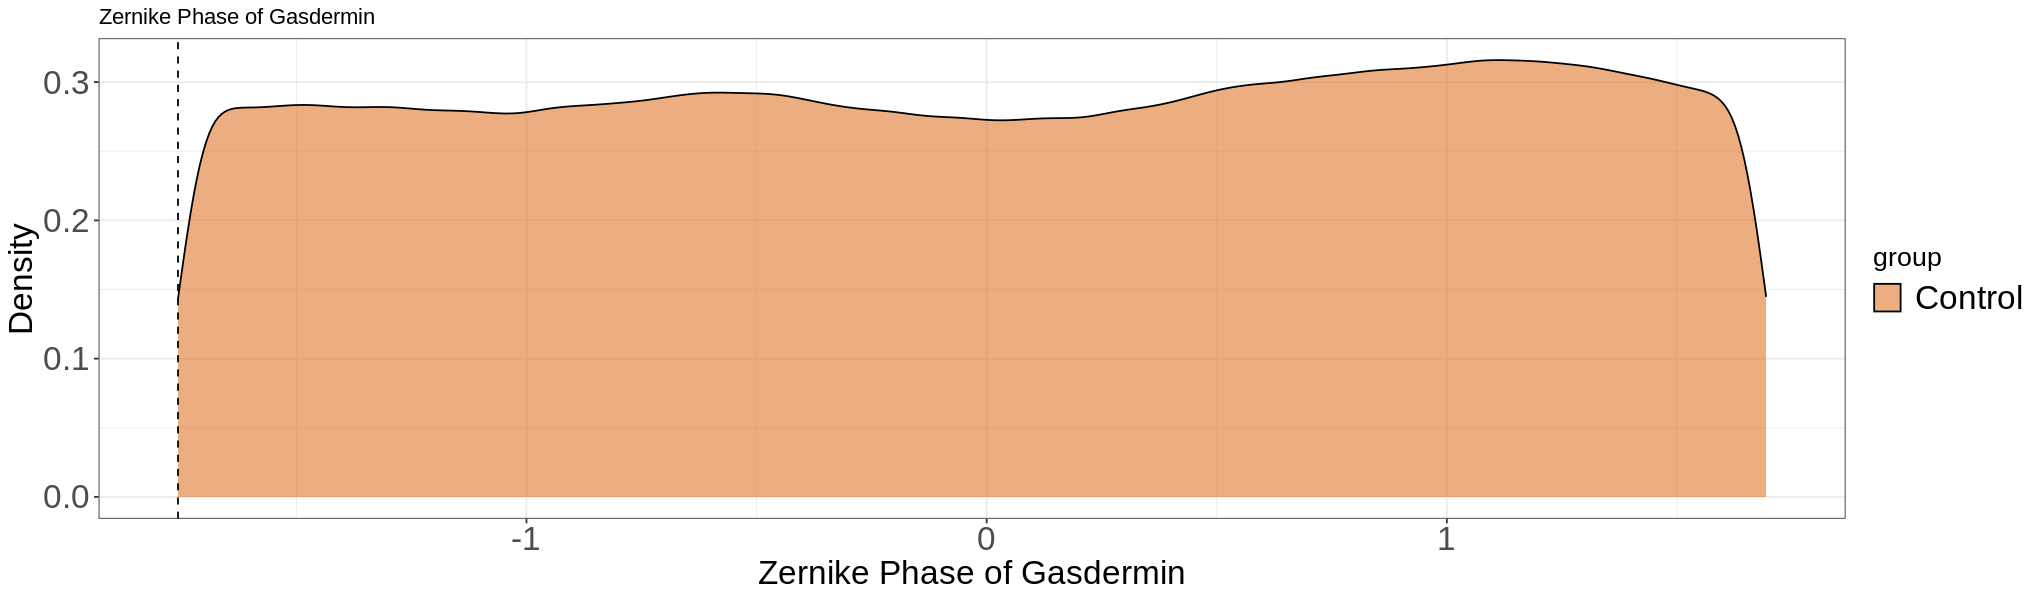

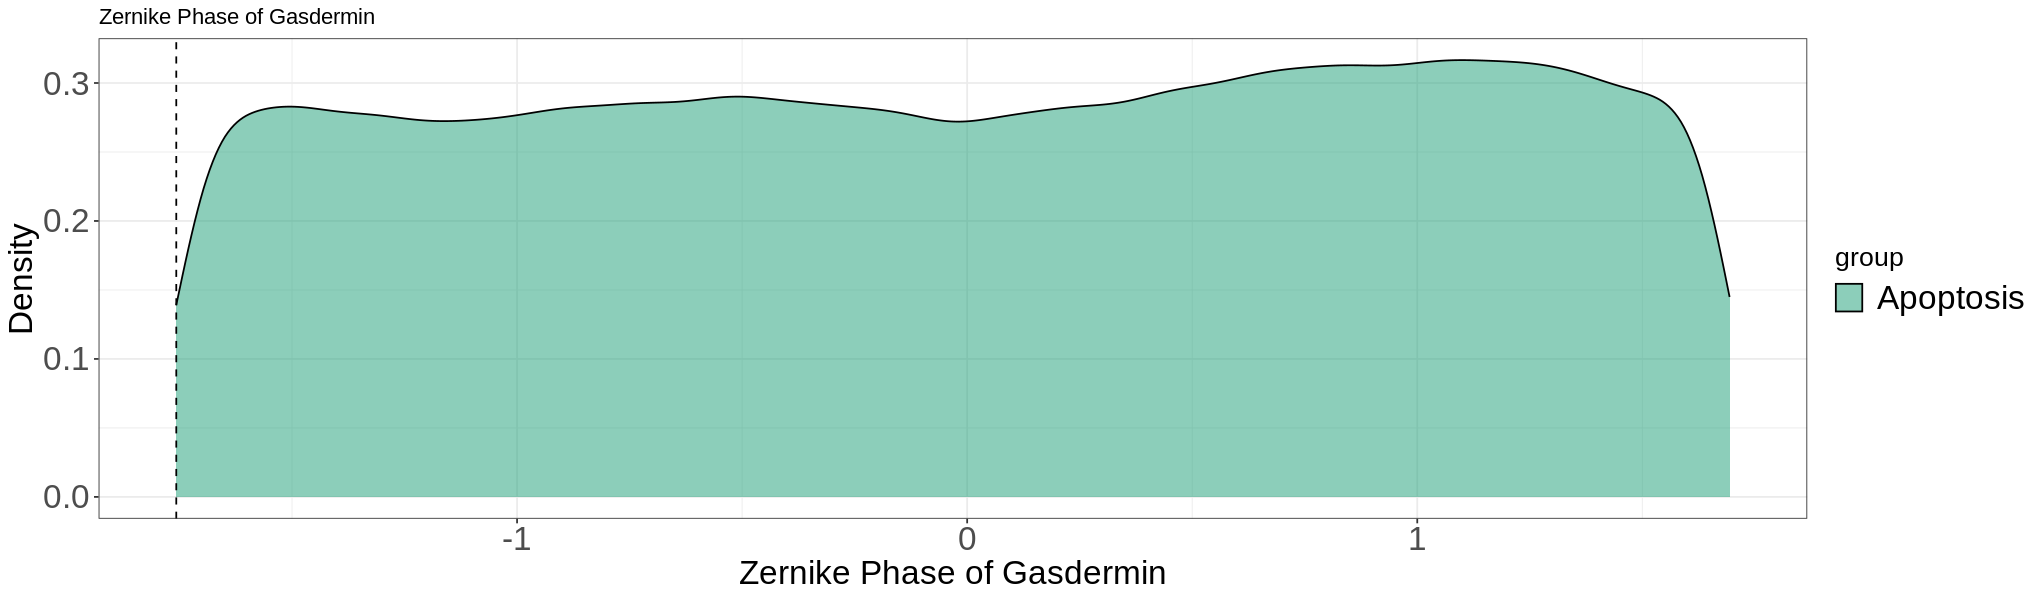

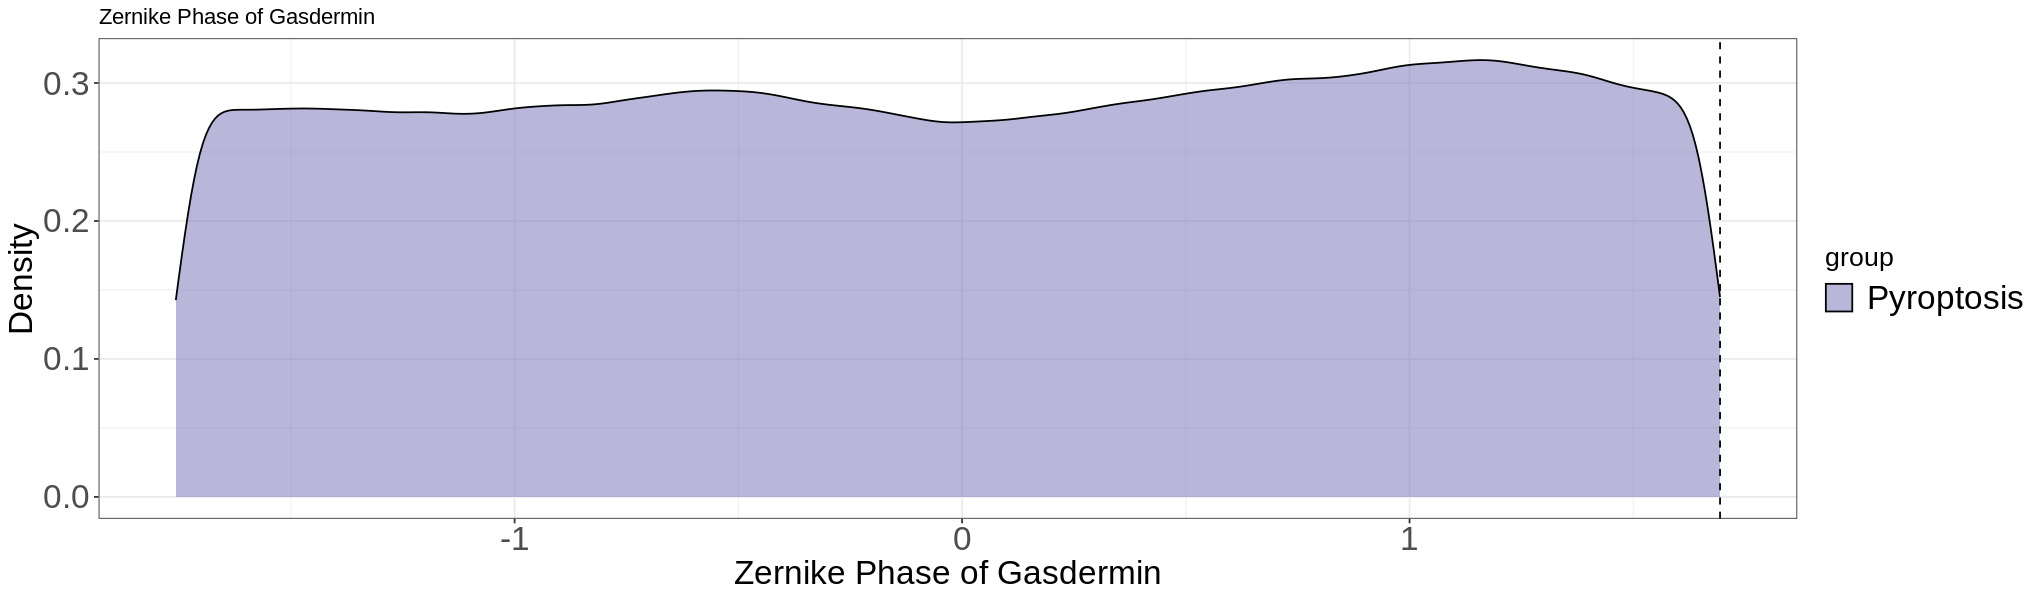

In [40]:
width <- 17
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# histogram of the zernike phase correlation of gasdermin 9_1
hist_plot_control <- (
    ggplot(control_df, aes(x = Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1))
    + geom_density(aes(fill = group), alpha = 0.5)
    # change color of the fill
    + scale_fill_manual(values = brewer.pal(3, "Dark2")[2])
    + figure_theme
    + labs(
        x = "Zernike Phase of Gasdermin",
        y = "Density",
        title = "Zernike Phase of Gasdermin"
    )
    # add verticle line per facet 
    + geom_vline(
        aes(xintercept = control_value),
        color = "black",
        linetype = "dashed",

    )
)

hist_plot_apoptosis <- (
    ggplot(apoptosis_df, aes(x = Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1))
    + geom_density(aes(fill = group), alpha = 0.5)
    # change color of the fill
    + scale_fill_manual(values = brewer.pal(3, "Dark2")[1])
    + figure_theme
    + labs(
        x = "Zernike Phase of Gasdermin",
        y = "Density",
        title = "Zernike Phase of Gasdermin"
    )
    # add verticle line per facet 
    + geom_vline(
        aes(xintercept = apoptosis_value),
        color = "black",
        linetype = "dashed",

    )
)

hist_plot_pyroptosis <- (
    ggplot(pyroptosis_df, aes(x = Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1))
    + geom_density(aes(fill = group), alpha = 0.5)
    # change color of the fill
    + scale_fill_manual(values = brewer.pal(3, "Dark2")[3])
    + figure_theme
    + labs(
        x = "Zernike Phase of Gasdermin",
        y = "Density",
        title = "Zernike Phase of Gasdermin"
    )
    # add verticle line per facet 
    + geom_vline(
        aes(xintercept = pyroptosis_value),
        color = "black",
        linetype = "dashed",

    )
)

hist_plot_control
hist_plot_apoptosis
hist_plot_pyroptosis

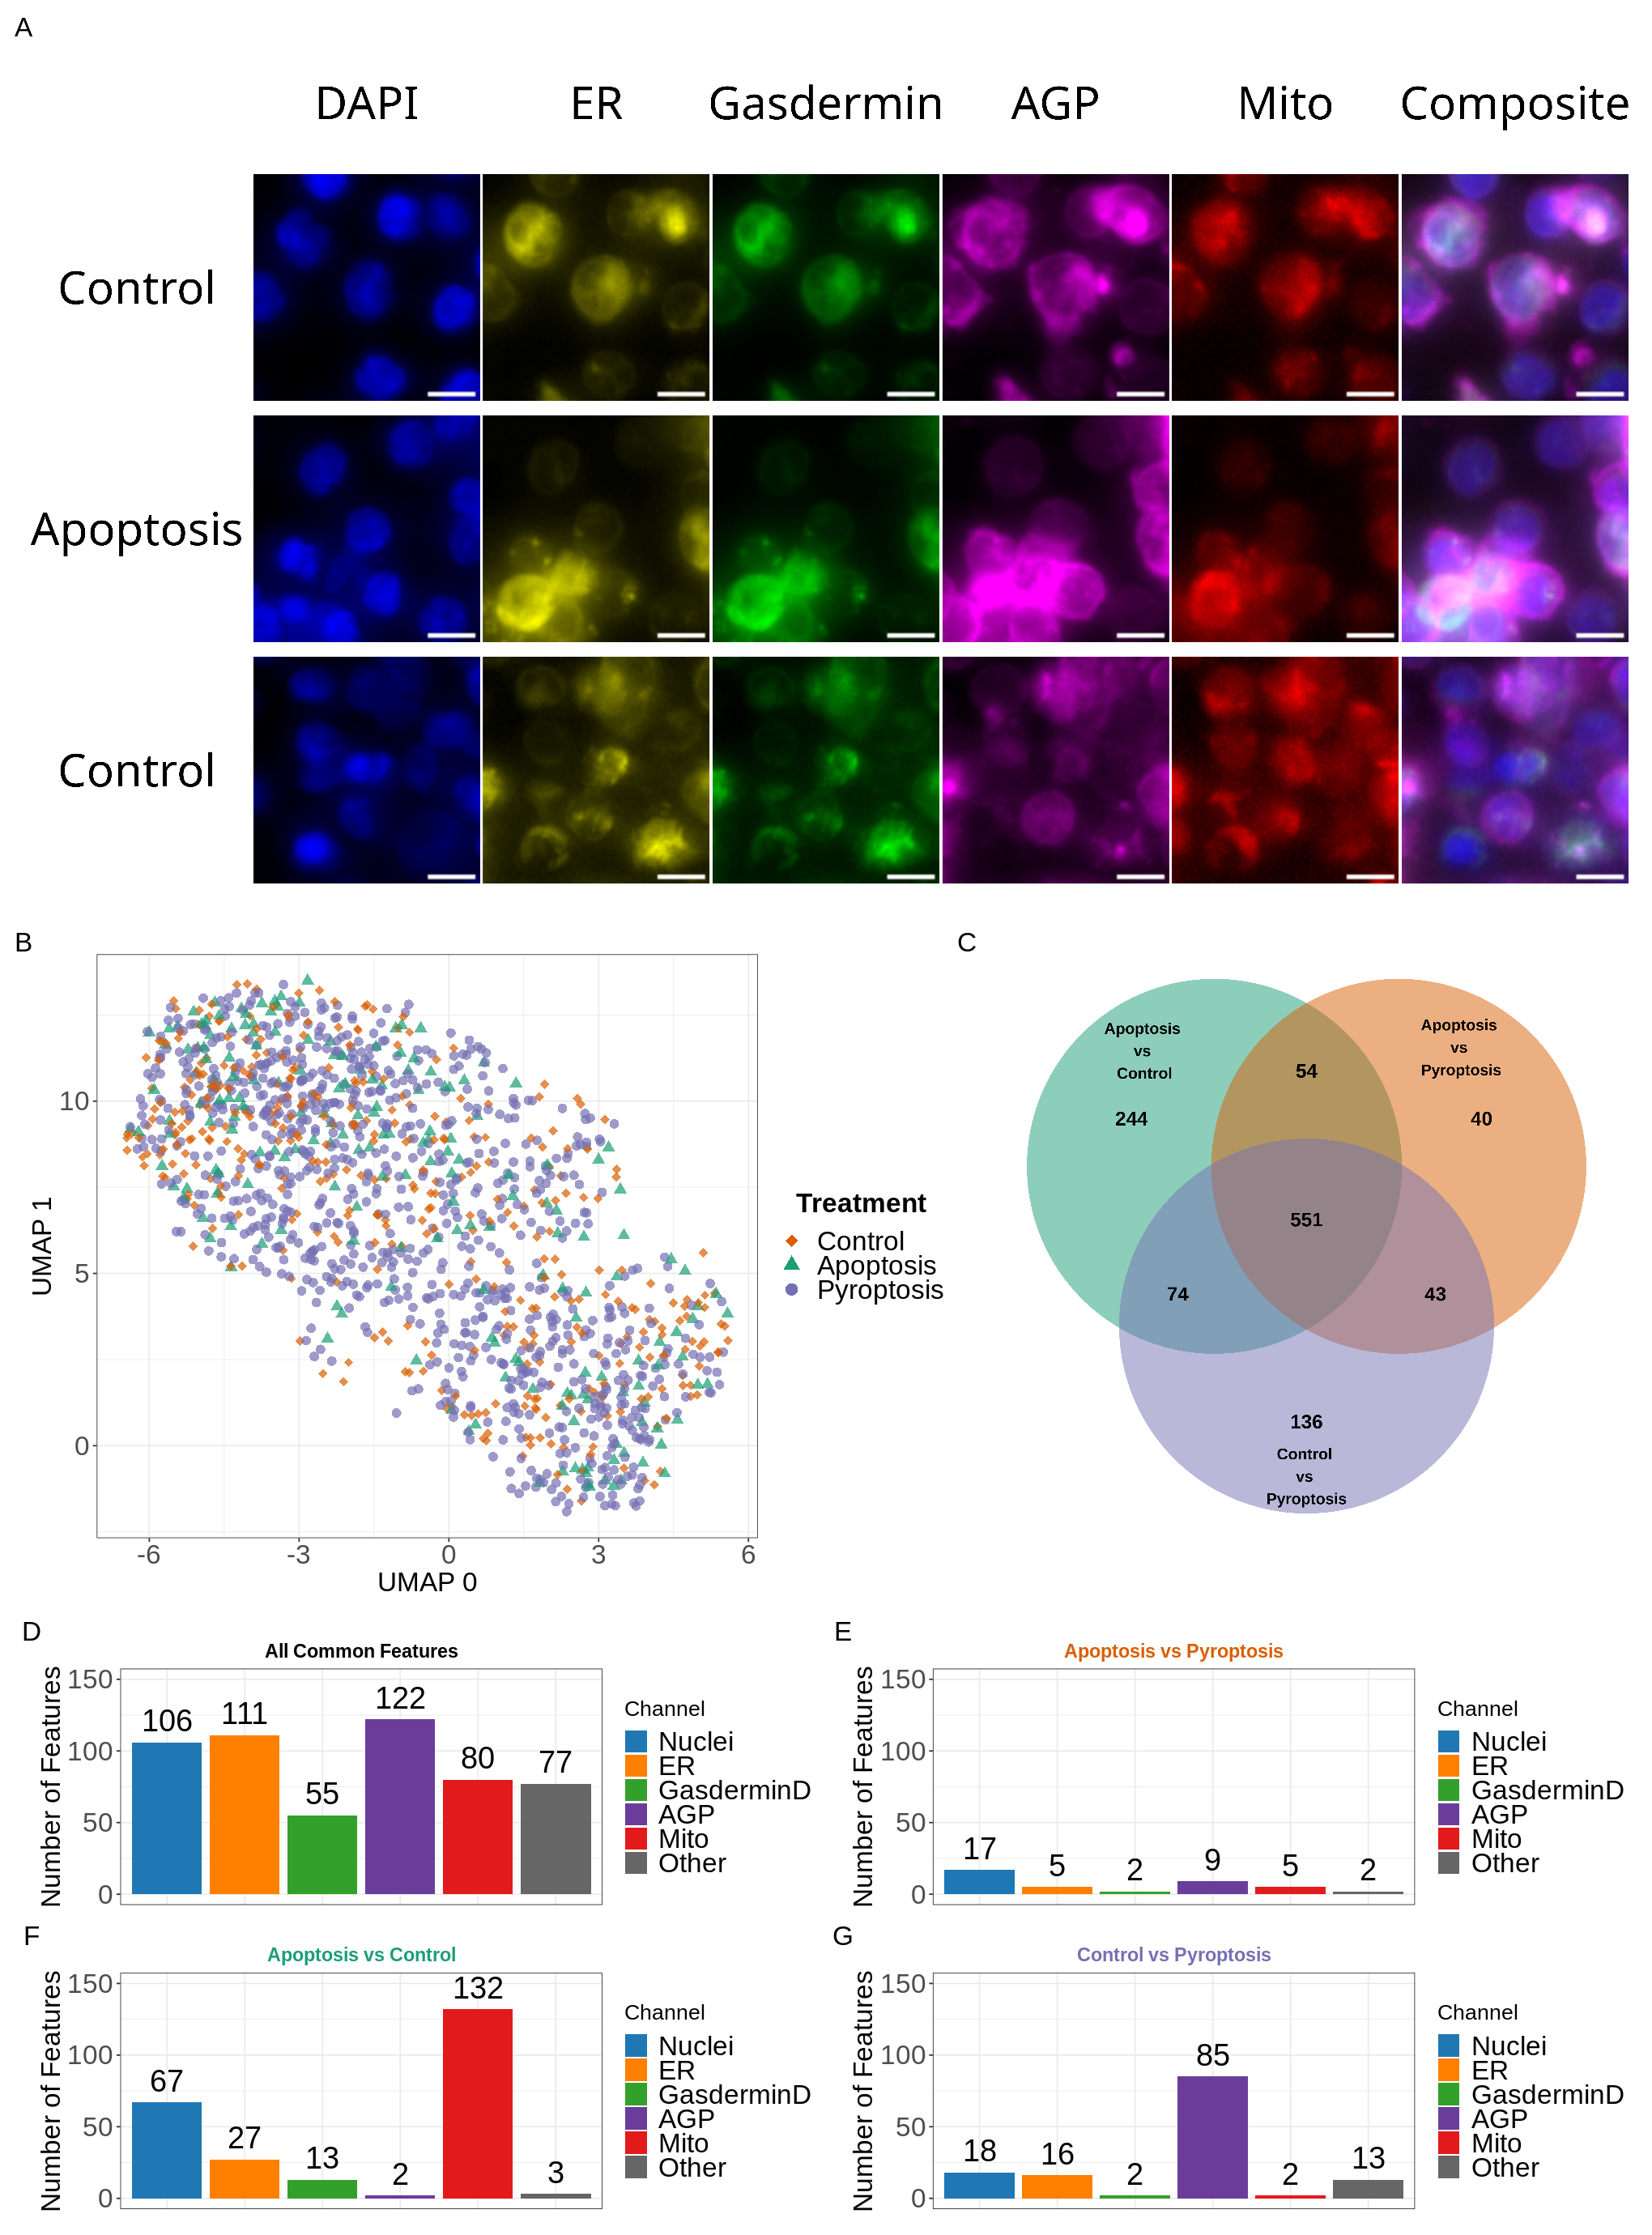

In [41]:
layout <- c(
    area(t=1, b=3, l=1, r=4), 
    area(t=4, b=5, l=1, r=2),
    area(t=4, b=5, l=3, r=4),
    area(t=6, b=7, l=1, r=4)
)

# patch work the plots together
# set plot size
width <- 17
height <- 23
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)

fig3 <- (
    wrap_elements(full = montage)
    # montage
    + umap_plot_selected_death_type
    + venn_diagram_image
    + wrap_elements(full = sub_figure3)
    # + sub_figure3
    + plot_layout(design = layout, widths = c(8,8 ))
    # make bottom plot not align
    + plot_annotation(tag_levels = list(c("A", "B", "C"))) & theme(plot.tag = element_text(size = 20))

)
ggsave(
    filename = file.path("..","figures",paste0(cell_type,"_figure3.png")),
    plot = fig3,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)

fig3


In [42]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Pop!_OS 22.04 LTS

Matrix products: default
BLAS/LAPACK: /home/lippincm/miniconda3/envs/Interstellar/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Polychrome_1.5.1      ggvenn_0.1.10         lubridate_1.9.3      
 [4] forcats_1.0.0         readr_2.1.4           tidyr_1.3.0          
 [7] tibble_3.2.1          tidyverse_2.0.0       VennDiagram_1.7.3    
[10] futile.logger_1.4.3   purrr_1.0.1           stringr_1.5.0        